# Gaussian process regression with varying output noise

This notebook shows how to construct a Gaussian process model where different noise is assumed for different data points. The model is:

$$f(\cdot) \sim \mathcal{GP}\big(0, k(\cdot, \cdot)\big)$$
$$y_i | f, x_i \sim \mathcal N\big(y_i; f(x_i), \sigma^2_i\big)$$

We'll demonstrate two methods. In the first demonstration, we'll assume that the noise variance is known for every data point. We'll incorporate the known noise variances $\sigma^2_i$ into the data matrix $\mathbf Y$, make a likelihood that can deal with this structure, and implement inference using Variational GPs with natural gradients (#TODO no natural gradients in GPflow 2 yet). 

In the second demonstration, we'll assume that the noise variance is not known, but we'd like to estimate it for different groups of data. We'll show how to construct an appropriate likelihood for this task and set up inference similarly to the first demonstration, with optimisation over the noise variances. 


In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Demo 1: known noise variances
### Generate synthetic data
We create a utility function to generate synthetic data, including noise that varies amongst the data:

In [2]:
np.random.seed(1)  # for reproducibility

def generate_data(N=80):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    NoiseVar = 2 * np.exp(-(X - 2)**2 / 4) + 0.3  # Noise variances
    Y = F + np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
    return X, Y, NoiseVar

X, Y, NoiseVar = generate_data()

Here's a plot of the data, with error bars representing two standard deviations:

/home/felix/anaconda3/envs/gpflow2/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


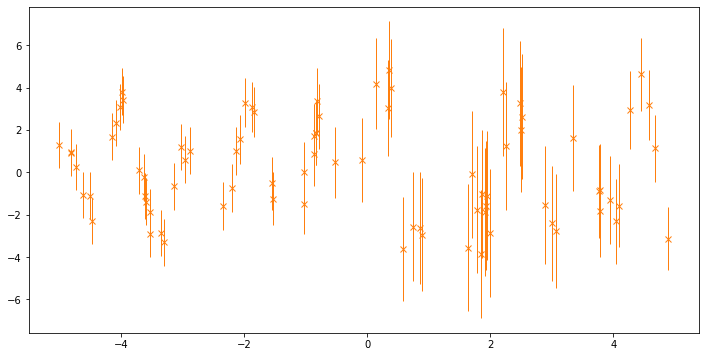

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
_ = ax.errorbar(X, Y, yerr=2*(np.sqrt(NoiseVar)), marker='x', lw=0, elinewidth=1., color='C1')

### Make a Y matrix that includes the variances
We need to tell the GP model what the variance is for each data point. To do this, we'll concatenate the observations with the variances into a single data matrix:

In [4]:
Y_data = np.hstack([Y, NoiseVar])

### Make a new likelihood

To cope with this data structure, we'll build a new likelihood. Note how the code extracts the observations `Y` and the variances `NoiseVar` from the data. For more information on creating new likelihoods, see [Likelihood design](../tailor/likelihood_design.ipynb). Here, we're implementing the `log_prob` function (which computes the log-probability of the data given the latent function) and `variational_expectations`, which computes the expected log-probability under a Gaussian distribution on the function, and is needed in the evaluation of the evidence lower bound (ELBO). Check out the docstring for the `Likelihood` object for more information on what these functions do. 

In [5]:
class HetGaussian(gpflow.likelihoods.Likelihood):
    def log_prob(self, F, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0:1], Y[:, 1:2]
        return gpflow.logdensities.gaussian(Y, F, NoiseVar)

    def conditional_mean(self, F):
        raise NotImplementedError

    def conditional_variance(self, F):
        raise NotImplementedError

    def variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0:1], Y[:, 1:2]
        return -0.5 * np.log(2 * np.pi) - 0.5 * tf.math.log(NoiseVar) \
               - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar

### Put it together with Variational Gaussian Process (VGP)
Here we'll build a variational GP model with the previous likelihood on the dataset that we generated. We'll use the natural gradient optimiser (see [Natural gradients](natural_gradients.ipynb) for more information) (#TODO no natural gradients in GPflow 2 yet).

The variational GP object is capable of variational inference with any GPflow-derived likelihood. Usually, the inference is an inexact (but pretty good) approximation, but in the special case considered here, where the noise is Gaussian, it will achieve exact inference. Optimising over the variational parameters is easy using the natural gradients method, which provably converges in a single step. 

In [6]:
# model construction (notice that num_latent is 1)
likelihood = HetGaussian()
kern = gpflow.kernels.Matern52(lengthscale=0.5)
model = gpflow.models.VGP((X, Y_data), kernel=kern, likelihood=likelihood, num_latent=1)

In [7]:
@tf.function
def objective_closure():
    return model.neg_log_marginal_likelihood()

opt = gpflow.optimizers.Scipy()
opt.minimize(objective_closure,
             model.trainable_variables,
             options=dict(maxiter=100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


      fun: 139.9419819467052
 hess_inv: array([[ 6.00243085e-02,  2.67789649e-01, -3.16458107e-02, ...,
         3.36228833e-03, -3.64063086e-16, -1.22815854e-03],
       [ 2.67789649e-01,  3.19247365e+00, -2.83526096e-01, ...,
         2.85260783e-02,  3.24088151e-15, -6.90876275e-02],
       [-3.16458107e-02, -2.83526096e-01,  8.33983026e-02, ...,
        -4.32772375e-03, -4.97924278e-16, -9.99068170e-04],
       ...,
       [ 3.36228833e-03,  2.85260783e-02, -4.32772375e-03, ...,
         9.97681475e-01, -6.44274912e-16, -1.86286341e-03],
       [-3.64063086e-16,  3.24088151e-15, -4.97924278e-16, ...,
        -6.44274912e-16,  1.00000000e+00, -4.85357193e-16],
       [-1.22815854e-03, -6.90876275e-02, -9.99068170e-04, ...,
        -1.86286341e-03, -4.85357193e-16,  8.77102578e-01]])
      jac: array([ 2.44168389e-03, -6.85690934e-04, -4.17062592e-04, ...,
       -1.15844810e-04, -3.17893560e-17, -2.72213363e-04])
  message: 'Maximum number of iterations has been exceeded.'
     nfev

/home/felix/anaconda3/envs/gpflow2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


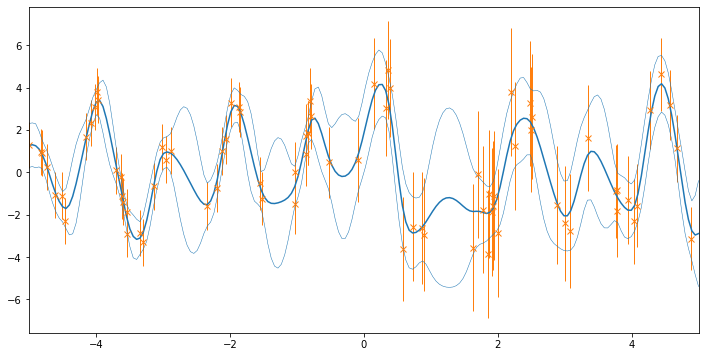

In [13]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

plt.figure(figsize=(12, 6))
plt.plot(xx, mu, 'C0')
plt.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
plt.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

plt.errorbar(X, Y, yerr=2*(np.sqrt(NoiseVar)), marker='x', lw=0, elinewidth=1., color='C1')
_ = plt.xlim(-5, 5)

### Questions for the reader
1) What is the difference in meaning between the orange vertical bars and the blue regions in the prediction?

2) Why did we not implement `conditional_mean` and `conditional_var` in the HetGaussian likelihood? What could be done here?

2) What are some better kernel settings for this dataset? How could they be estimated?

## Demo 2: grouped noise variances

In this demo, we won't assume that the noise variances are known, but we will assume that they're known in two groups. This example represents a case where we might know that an instrument has varying fidelity for different regions, but we do not know what those fidelities are. 

Of course it would be straightforward to add more groups, or even one group per data point. We'll stick with two for simplicity. 

In [14]:
np.random.seed(1)  # for reproducibility and to make it independent from demo 1

### Generate data

In [15]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    groups = np.where(X>0, 0, 1)  
    NoiseVar = np.array([0.02, 0.5])[groups]  # Different variances for the two groups
    Y = F + np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
    return X, Y, groups

X, Y, groups = generate_data()

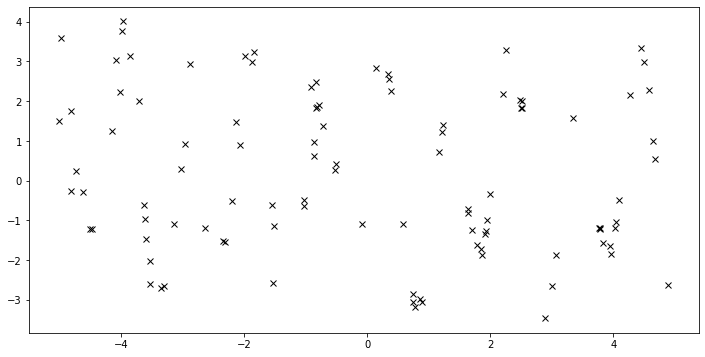

In [16]:
# here's a plot of the raw data.
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
_ = ax.plot(X, Y, 'kx')

### Data structure

In this case, we need to let the model know which group each data point belongs to. We'll use a similar trick to the above, stacking the group identifier with the data:

In [17]:
Y_data = np.hstack([Y, groups])

### Build a likelihood

This time, we'll use a built-in likelihood, `SwitchedLikelihood`, which is a container for other likelihoods, and applies them to the first `Y_data` column depending on the index in the second. We're able to access and optimise the parameters of those likelihoods. Here, we'll (incorrectly) initialise the variances of our likelihoods to 1, to demonstrate how we can recover reasonable values for these through maximum-likelihood estimation. 

In [18]:
likelihood = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=1.0),
                                                    gpflow.likelihoods.Gaussian(variance=1.0)])

In [19]:
# model construction (notice that num_latent is 1)
kern = gpflow.kernels.Matern52(lengthscale=0.5)
model = gpflow.models.VGP((X, Y_data), kernel=kern, likelihood=likelihood, num_latent=1)

In [20]:
@tf.function
def objective_closure():
    return model.neg_log_marginal_likelihood()

from gpflow.utilities import set_trainable
set_trainable(model.kernel, False)
set_trainable(model.likelihood, False)

opt = gpflow.optimizers.Scipy()
opt.minimize(objective_closure,
             model.trainable_variables,
             options=dict(maxiter=100))

      fun: 213.9556976206204
 hess_inv: array([[ 1.32471309e-01, -1.21045863e-02,  3.48097970e-03, ...,
        -7.39324257e-08,  5.95687618e-10,  1.24662876e-05],
       [-1.21045863e-02,  2.32849633e-01,  1.66566220e-02, ...,
        -1.42332409e-07, -1.09484833e-07, -6.34771986e-06],
       [ 3.48097970e-03,  1.66566220e-02,  4.85419602e-01, ...,
        -1.98398714e-07, -1.71422338e-07,  3.23602977e-05],
       ...,
       [-7.39324257e-08, -1.42332409e-07, -1.98398714e-07, ...,
         1.00000000e+00, -8.33243314e-14,  2.28906336e-09],
       [ 5.95687618e-10, -1.09484833e-07, -1.71422338e-07, ...,
        -8.33243314e-14,  1.00000000e+00,  1.67437588e-09],
       [ 1.24662876e-05, -6.34771986e-06,  3.23602977e-05, ...,
         2.28906336e-09,  1.67437588e-09,  9.99999447e-01]])
      jac: array([-2.54676806e-06,  3.02506590e-06,  4.22613230e-07, ...,
       -2.68044735e-11, -2.20443470e-11,  2.15611127e-09])
  message: 'Optimization terminated successfully.'
     nfev: 72
     

We've now fitted the VGP model to the data, but without optimising over the hyperparameters. Plotting the data, we see that the fit is not terrible, but hasn't made use of our knowledge of the varying noise. 

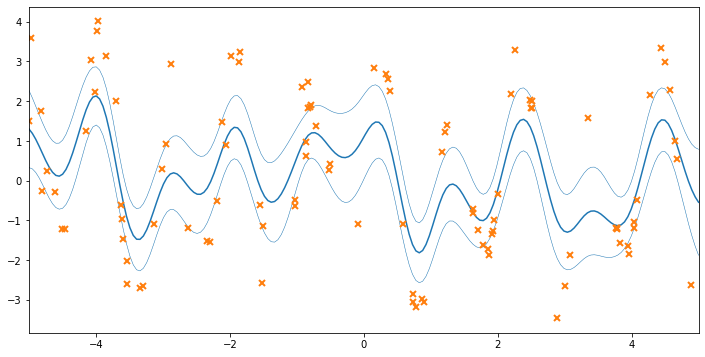

In [21]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(xx, mu, 'C0')
ax.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
ax.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

ax.plot(X, Y, 'C1x', mew=2)
_ = ax.set_xlim(-5, 5)

### Optimising the noise variances
Here we'll optimise over both the noise variance and the variational parameters, applying natural gradients interleaved with the Adam optimiser. See [Natural gradients](natural_gradients.ipynb) for more details and explanation (#TODO no natural gradients in GPflow 2 yet).

In [22]:
likelihood = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(variance=1.0),
                                                    gpflow.likelihoods.Gaussian(variance=1.0)])
kern = gpflow.kernels.Matern52(lengthscale=0.5)
model = gpflow.models.VGP((X, Y_data), kernel=kern, likelihood=likelihood, num_latent=1)

@tf.function
def objective_closure():
    return model.neg_log_marginal_likelihood()

opt.minimize(objective_closure,
             model.trainable_variables,
             options=dict(maxiter=100))

      fun: 137.77111216784775
 hess_inv: array([[ 4.35607137e-02,  8.93275441e-02, -2.68113097e-03, ...,
         2.62076567e-05,  2.74399792e-05,  1.13049655e-03],
       [ 8.93275441e-02,  3.82477156e-01,  3.34275836e-02, ...,
         9.01048369e-05,  9.34960953e-05, -6.52077525e-03],
       [-2.68113097e-03,  3.34275836e-02,  5.01910198e-01, ...,
         4.99223931e-06,  4.67448919e-06, -1.60149877e-03],
       ...,
       [ 2.62076567e-05,  9.01048369e-05,  4.99223931e-06, ...,
         1.00000002e+00,  2.31144423e-08, -2.96064957e-06],
       [ 2.74399792e-05,  9.34960953e-05,  4.67448919e-06, ...,
         2.31144423e-08,  1.00000002e+00, -3.15193410e-06],
       [ 1.13049655e-03, -6.52077525e-03, -1.60149877e-03, ...,
        -2.96064957e-06, -3.15193410e-06,  9.99288719e-01]])
      jac: array([ 1.68507139e+00, -5.12339682e+00,  2.06170690e+00, ...,
       -7.40411902e-05, -9.89606280e-05,  1.34460840e-02])
  message: 'Maximum number of iterations has been exceeded.'
     nfe

### Plotting the fitted model

Now that the noise variances have been estimated, we can see the final model fit.
The predictive variance is higher on the left side of the plot, where we know that the data have different variance.
We'll plot the known underlying function in green to see how effectively we've recovered the ground truth.
We can also print the model to examine the estimated noise variances:

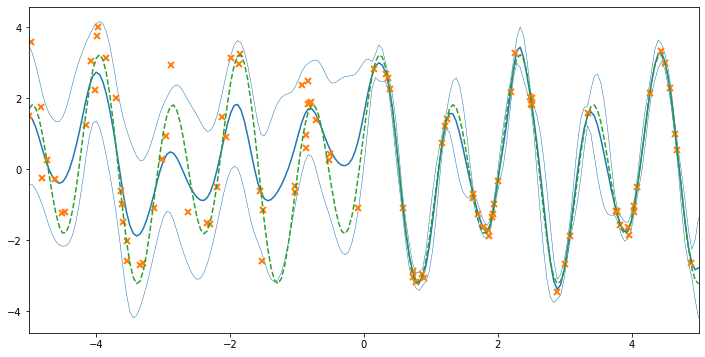

In [23]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(xx, mu, 'C0')
ax.plot(xx, mu + 2*np.sqrt(var), 'C0', lw=0.5)
ax.plot(xx, mu - 2*np.sqrt(var), 'C0', lw=0.5)

ax.plot(X, Y, 'C1x', mew=2)
ax.set_xlim(-5, 5)
_ = ax.plot(xx, 2.5 * np.sin(6 * xx) + np.cos(3 * xx), 'C2--')

In [24]:
from gpflow.utilities import print_summary
print_summary(model, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,True,(),float64,2.7097102758212834
VGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.2850341617314476
VGP.likelihood.SwitchedLikelihood_likelihoods[0].variance,Parameter,Softplus,True,(),float64,0.019837537730418225
VGP.likelihood.SwitchedLikelihood_likelihoods[1].variance,Parameter,Softplus,True,(),float64,0.3005387228647371
VGP.q_mu,Parameter,,True,"(100, 1)",float64,[[0.9472866...
VGP.q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[2.25232947e-01, 0.00000000e+00, 0.00000000e+00..."
